In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import ml_collections 
import deepchest

## Model Configuration

In [2]:
config = ml_collections.ConfigDict()

config.batch_size = 64
config.num_steps = 300

# See preprocessing.py, if you replace with ";" no preprocessing is done
config.preprocessing_train_eval = "independent_dropout(.2);"

config.use_validation_split = False

# If validation split is false, then train will have 4/5 of data and test 1/5
# If validation split is true, then train will have 3/5 of data, test 1/5 and val 1/5
config.num_folds = 5 

# gpu workers
config.num_workers = 0

# dataset 
config.images_directory = "dataset/images/"
config.labels_file = "dataset/labels/diagnostic.csv"

# Fold seed
config.random_state = 0

# Where the indices are saved
config.save_dir = "model_saved/"
config.export_folds_indices_file = "indices.csv"

# Don't modify these (should not have been in the config)
config.test_fold_index = 0
config.delta_from_test_index_to_validation_index = 1

# Data Preprocessing

In [3]:
train_loader, test_loader, validation_loader = deepchest.dataset.get_data_loaders(
         config=config
    )

d:\LUS-COVID-CHALLENGE\venv\lib\site-packages\torchvision\transforms\transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Split infos:


┏━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ split ┃ size ┃ negative ┃  positive ┃
┡━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│ train │  229 │ 70 (31%) │ 159 (69%) │
│ test  │   57 │ 17 (30%) │  40 (70%) │
└───────┴──────┴──────────┴───────────┘

In [4]:
batch = next(iter(train_loader))
images = batch["images"]
labels = batch["label"]
masks = batch["mask"]
sites = batch["sites"]

Patient 0 | label = 1


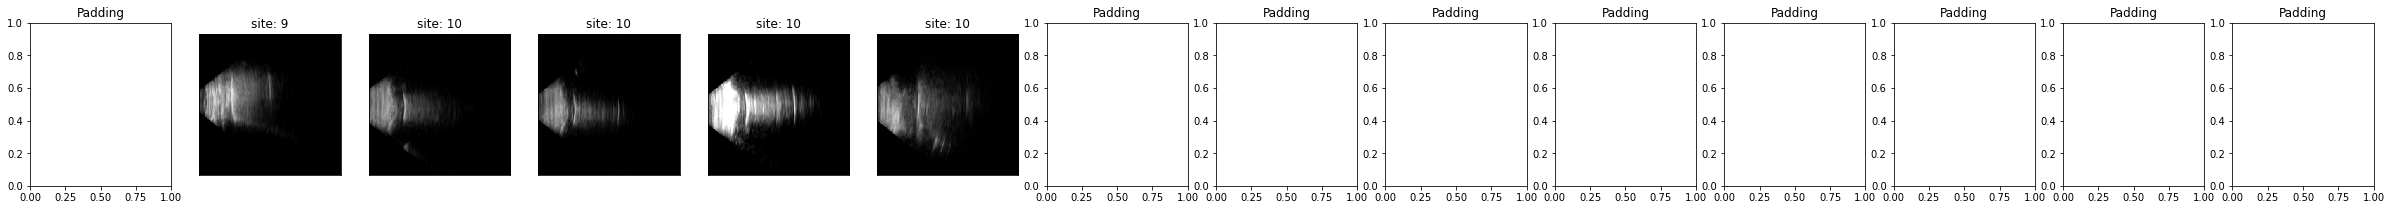

Patient 1 | label = 0


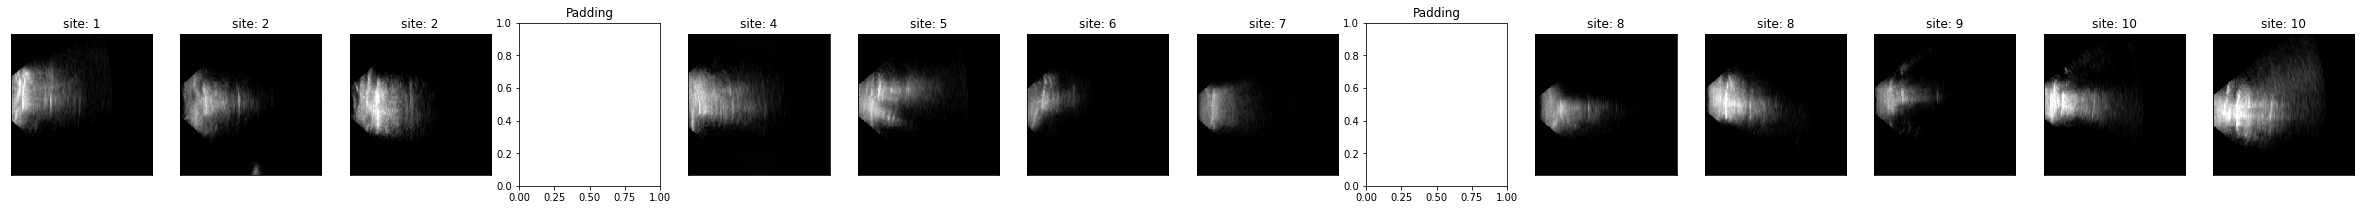

In [5]:
for patient_i, (patient_images, label, mask, site) in enumerate(zip(images, labels, masks, sites)):
    print(f"Patient {patient_i} | label = {label.item()}")
    num_images = masks.shape[-1]

    f, axes = plt.subplots(1, num_images, figsize=(3*num_images, 3))
    for im, not_padding, ax, st in zip(patient_images, mask, axes, site):
        if not_padding > 0:
            ax.title.set_text('site: {}'.format(st))
            ax.matshow(im.transpose(0, 2))
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.title.set_text('Padding')

    plt.show()

How to evaluate model (you can also use your own methods)
```python
label_names = utils.get_label_names(config.labels_file)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0") if use_cuda else torch.device("cpu") 

scores, labels = utils.model_evaluation(**model**, train_loader, device)
train_metrics = utils.compute_metrics(labels, scores, label_names)

train_metrics
```

# Apply simple model

In [6]:
import copy
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

if torch.cuda.is_available(): print("CUDA is available")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if False else "cpu")

CUDA is available


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # load pretrained model for feature extraction
        self.feature_extractor = torchvision.models.resnet18(pretrained=True)
        # freeze feature extractor part
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # replace last layer with an indentity layer (to remove the last fc layer)
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity(num_ftrs)

        # add new fc layers
        self.fc1 = nn.Linear(num_ftrs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, inputs):
        # inputs is a tensor of batch_size x num_sites x 3 x 224 x 224

        feature_vectors = []
        for i in range(inputs.shape[1]):
            each_image_site = inputs[:, i, :, :, :]
            each_image_site = each_image_site.view(inputs.shape[0], inputs.shape[2], inputs.shape[3], inputs.shape[4])

            # x is now batch_size x 3 x 224 x 224
            x = self.feature_extractor(each_image_site)
            feature_vectors.append(x)
        # stack all feature vectors to a new dimension
        x = torch.stack(feature_vectors, dim=0)
        # average all feature vectors
        x = torch.mean(x, dim=0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in {'train': train_loader, 'test': test_loader, 'val': test_loader}[phase]:
                inputs, labels = batch['images'], batch['label']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    preds = torch.zeros_like(outputs)
                    preds[outputs > 0.5] = 1
                    preds[outputs <= 0.5] = 0
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(preds, '\n', labels.data)
            if phase == 'train':
                scheduler.step()
            print(running_corrects)
            epoch_loss = running_loss / inputs.size(0)
            epoch_acc = running_corrects / inputs.size(0)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train model

In [9]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

criterion = nn.BCEWithLogitsLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())
optimizer_conv = optim.SGD(params, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
tensor([0., 0.], device='cuda:0') 
 tensor([0, 1], device='cuda:0')
tensor([0., 0.], device='cuda:0') 
 tensor([0, 0], device='cuda:0')
tensor([0., 0.], device='cuda:0') 
 tensor([1, 1], device='cuda:0')
tensor(3, device='cuda:0')
train Loss: 2.1154 Acc: 1.5000
0
val Loss: 0.0000 Acc: 0.0000

Epoch 1/1
----------
0
train Loss: 0.0000 Acc: 0.0000
0
val Loss: 0.0000 Acc: 0.0000

Training complete in 0m 43s
Best val Acc: 0.000000


In [11]:
# saving the model
torch.save(model_conv.state_dict(), 'simple_model')

## Evaluation

In [12]:
model = Net()
model.load_state_dict(torch.load('simple_model'))
model.eval()
model.to(device)

Net(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [13]:
label_names = deepchest.utils.get_label_names(config.labels_file)

use_cuda = torch.cuda.is_available()
# use_cuda = False

device = torch.device("cuda:0") if use_cuda else torch.device("cpu")

scores, labels = deepchest.utils.model_evaluation(model, test_loader, device)
train_metrics = deepchest.utils.compute_metrics(labels, scores, label_names)

train_metrics

{'loss': tensor(0.6916),
 'ece': tensor(0.2001),
 'true_positive': 0,
 'true_negative': 17,
 'false_negative': 40,
 'false_positive': 0,
 'balanced_accuracy': 0.5,
 'false_positive_rate': array([0.        , 0.        , 0.        , 0.05882353, 0.05882353,
        1.        ]),
 'true_positive_rate': array([0.   , 0.025, 0.25 , 0.25 , 0.5  , 1.   ]),
 'roc_auc': 0.7205882352941175,
 'roc': Figure({
     'data': [{'hovertemplate': 'False Positive Rate=%{x}<br>True Positive Rate=%{y}<extra></extra>',
               'legendgroup': '',
               'line': {'color': '#636efa', 'dash': 'solid'},
               'marker': {'symbol': 'circle'},
               'mode': 'lines',
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'type': 'scatter',
               'x': array([0.        , 0.        , 0.        , 0.05882353, 0.05882353, 1.        ]),
               'xaxis': 'x',
               'y': array([0.   , 0.025, 0.25 , 0.25 , 0.5  ,